# Caso práctico

Trabajamos como científicos de datos para una empresa de retail que, debido al cambio en los hábitos de consumo de los clientes, está potenciando ampliamente el servicio de venta online. La empresa quiere realizar un modelo de aprendizaje automático para clasificar a los clientes en función de la probabilidad de generar ingresos al comprar en la web.

El objetivo es realizar una serie de acciones específicas para los clientes que es más probable que hagan compras en la web.

Para ello, la empresa ha ido recopilando datos con su herramienta de Google Analytics. Cuenta con datos de sesiones, cada una de ellas de un cliente distinto en un periodo de un año.

## Información de los datos

 1. El conjunto de datos consta de diez atributos numéricos y ocho categóricos.
 
 
 
 2. El atributo **revenue** puede ser usado como la etiqueta de la clase.
 
 
 
 3. **Administrative, administrative duration, informational, informational duration, product related** y **product related duration** representan el número de diferentes tipos de páginas visitadas por el visitante en esa sesión y el tiempo total dedicado a cada una de estas categorías de páginas. Los valores de estas características se derivan de la información del URL de las páginas visitadas por el usuario y se actualizan en tiempo real cuando el usuario realiza una acción, por ejemplo, pasar de una página a otra.
 
 
 
 4. Las características __bounce rate__, exit rate y page value representan las métricas medidas por Google Analytics para cada página del sitio de comercio electrónico.

    El valor de la característica bounce rate de una página web se refiere al porcentaje de visitantes que entran en el sitio desde esa página y luego salen (rebote) sin activar ninguna otra solicitud al servidor de análisis durante esa sesión.

    El valor de la característica __exit rate__ para una página web específica se calcula como para todas las visitas a la página, el porcentaje que fueron las últimas en la sesión.

    La función __Page Value__ representa el valor medio de una página web que un usuario ha visitado antes de completar una transacción de comercio electrónico.



 5. La característica de **special day** indica la cercanía de la hora de visita del sitio a un día especial específico (por ejemplo, el Día de la Madre, San Valentín) en el que es más probable que las sesiones finalicen con una transacción.

    El valor de este atributo se determina teniendo en cuenta la dinámica del comercio electrónico, como la duración entre la fecha del pedido y la fecha de entrega.

    Por ejemplo, para San Valentín, este valor toma un valor distinto de 0 entre el 2 y el 12 de febrero, 0 antes y después de esta fecha a menos que esté cerca de otro día especial, y su valor máximo de 1 el 8 de febrero.



 6. El conjunto de datos también incluye el sistema operativo, el navegador, la región, el tipo de tráfico, el tipo de visitante como visitante que regresa o como nuevo visitante, un valor booleano que indica si la fecha de la visita es de fin de semana, y el mes del año.

### NOTAS:

Lo que se pide es un modelo **end-to-end** como los vistos en prácticas en el módulo. En este caso, hay que aplicar tres modelos y escoger el mejor, pero la parte previa es común a los tres.

Se tendrán en cuenta la estructura del código, las interpretaciones y las justificaciones.

El esquema que se pone en las tareas es un esquema general. Si se necesita hacer alguna tarea, se puede llevar a cabo. También es posible aplicar cualquier otro algoritmo visto en el módulo, siempre justificando y haciendo las cosas con un sentido.


## Se pide

### 1. Realización de un análisis de las variables del dataset de Google Analytics como pueden ser histogramas, boxplots, etc. Cualquier otro análisis es bienvenido, siempre explicándolo y con un sentido de negocio.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

## Definición de funciones:

In [2]:
def relaciones_vs_target(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 4.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', density=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best') 

def hist_pos_neg_feat(x, y, density=0, nbins=11, targets=(0,1)):
    '''
    Representa las variables en x divididas en dos distribuciones
    según su valor de y sea 1 o 0
    '''
    fig_tot = len(x.columns)
    fig_tot_fila = 4.; fig_tamanio = 4.
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                   density = density, title=('%s' % feat))
        
def describe_columna(df):
    '''
    Creamos una función que nos ayude a automatizar parte del análisis descriptivo de cada columna de un dataframe
    '''
    columns_list = df.columns.values.tolist()
    for col in columns_list:
        print(f'Columna: {col}  -  Tipo de datos: {df[col].dtype}')
        print(f'Número de valores distintos: {df[col].nunique()}')
        print('Valores más frecuentes: \n')
        for i, v in df[col].value_counts().iloc[:10].items() :
            print(i, '\t', v)
        print("\n\n")

        

## Carga y lectura de datos

In [3]:
data = pd.read_csv("online_shoppers_intention.csv")

data.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


In [4]:
# Muestra el número de filas, columnas que hay en el dataset

print(u'- El número de filas en el dataset es: {}'.format(data.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(data.shape[1]))

- El número de filas en el dataset es: 12330
- El número de columnas en el dataset es: 18


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Como podemos observar, todas las variables parten de un tipo numérico, excepto *Month* y *VisitorType* 
(que son object),  y _Weekend_ y _Revenue_ (booleanas). Aunque, como veremos posteriormente, nos daremos cuenta que 
las numéricas continuas serán sólo las 10 primeras, hasta _SpecialDay_. 

El resto, desde _Month_ hasta el final, podemos tratarlas como variables categóricas, puesto que se trata de numéricas de tipo discreto, englobando un rango de valores muy reducido. 

## Preprocesamiento de datos
## Missings:

In [6]:
data.isnull().sum()  # tenemos 14 nulos en las primeras 8 columnas

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

In [7]:
columns_with_nulls = data.columns.values.tolist()[:8]

columns_with_nulls

['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates']

In [8]:
# Consultamos las observaciones con valores nulos

data[data["Administrative"].isnull()][columns_with_nulls]


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates
1065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
len(data[data["Administrative"].isnull()])

14

Ahora tenemos las certeza de que los 14 nulos de cada una de las 8 columnas pertenecen a las 
mismas observaciones. Esto puede que no sea muy importante de cara a la construcción del modelo
pero nos puede ayudar a entender que hay 14 usuarios de los que no tenemos ninguna información
respecto al tipo de página visitada ni tiempo empleado en la misma.

In [10]:
rows_with_nulls = len(data[data["Administrative"].isnull()])
total_rows =  data.shape[0]

print("El porcentaje de clientes de los que carecemos de información es: {} %".format
      (round((rows_with_nulls / total_rows)*100, 2)))

El porcentaje de clientes de los que carecemos de información es: 0.11 %


Como el porcentaje de nulos es prácticamente insignificante, no supondrá un problema para encontrar patrones de consumo generales, que es nuestro objetivo cuando entrenamos los modelos. 

Procederemos ahora a eliminar los valores nulos con el método **dropna()** de Pandas. 

In [11]:
data = data.dropna() # Eliminanos las observaciones con valores nulos

data.isnull().sum() # Comprobamos

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [12]:
'''
Aplicando nuestra función describe_columna, podemos obtener el número de valores distintos y más frecuentes
de las distintas columnas que componen el dataframe.
'''

describe_columna(data)

Columna: Administrative  -  Tipo de datos: float64
Número de valores distintos: 27
Valores más frecuentes: 

0.0 	 5754
1.0 	 1354
2.0 	 1114
3.0 	 915
4.0 	 765
5.0 	 575
6.0 	 432
7.0 	 338
8.0 	 287
9.0 	 225



Columna: Administrative_Duration  -  Tipo de datos: float64
Número de valores distintos: 3336
Valores más frecuentes: 

0.0 	 5857
4.0 	 56
5.0 	 53
7.0 	 45
11.0 	 42
6.0 	 41
14.0 	 37
9.0 	 35
-1.0 	 33
15.0 	 33



Columna: Informational  -  Tipo de datos: float64
Número de valores distintos: 17
Valores más frecuentes: 

0.0 	 9686
1.0 	 1041
2.0 	 727
3.0 	 380
4.0 	 222
5.0 	 99
6.0 	 78
7.0 	 36
9.0 	 15
8.0 	 14



Columna: Informational_Duration  -  Tipo de datos: float64
Número de valores distintos: 1259
Valores más frecuentes: 

0.0 	 9879
-1.0 	 33
9.0 	 33
7.0 	 26
6.0 	 26
10.0 	 26
13.0 	 23
12.0 	 23
8.0 	 22
16.0 	 22



Columna: ProductRelated  -  Tipo de datos: float64
Número de valores distintos: 311
Valores más frecuentes: 

1.0 	 625
2.0 	 460
3.0 	 456

Como anticipábamos, las columnas numéricas a partir de _Month_ son de tipo discreto, toman un número limitado de valores, por lo que podemos tratarlas como si fueran categóricas.

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12316 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12316 non-null  float64
 9   SpecialDay               12316 non-null  float64
 10  Month                    12316 non-null  object 
 11  OperatingSystems         12316 non-null  int64  
 12  Browser                  12316 non-null  int64  
 13  Region                   12316 non-null  int64  
 14  TrafficType           

## Categóricas a numéricas:

Es necesario convertir las variables categóricas a numéricas de cara a introducirlas en modelos, pero antes de transformar estas variables, podemos obtener un gráfico con los datos originales para entender el tratamiento que vamos a hacer con ellas. Para ello, vamos a seleccionar las variables cualitativas originales, y vamos a aplicar un diagrama de barras.

In [14]:
categorical_original_features = data.columns.values.tolist()[10:]

data[categorical_original_features][:3]

,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,Feb,1,1,1,1,Returning_Visitor,False,False
1,Feb,2,2,1,2,Returning_Visitor,False,False
2,Feb,4,1,9,3,Returning_Visitor,False,False


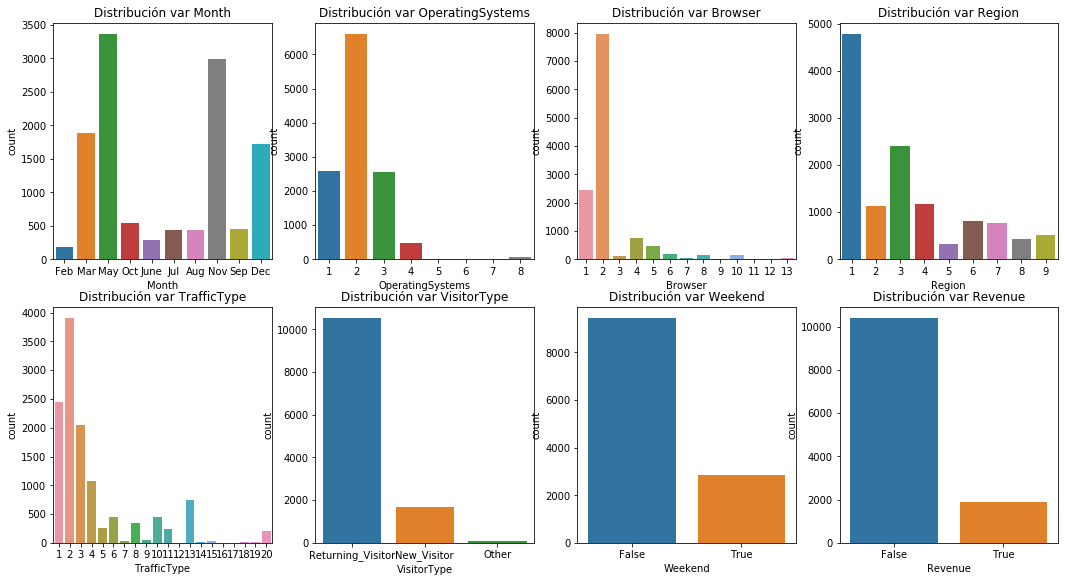

In [15]:
# Cómo se anticipaba en el módulo de estadística, gráfico apropiado para la representación variables categóricas, 
# es el gráfico de barra o el de tarta (pie chart)


plt.figure(figsize=(18,20))
for i, column in enumerate(data[categorical_original_features]):
    plt.subplot(4, 4, i+1)
    sns.countplot(data[column])
    plt.title('Distribución var {}'.format(column))
plt.show()

Como primeros análisis, vemos que hay 2 meses al año (Mayo y Noviembre) en los se producen muchas más visitas que el resto, seguidas de Marzo y Diciembre. El sistema operativo número 2 es el más abundante, al igual que el navegador 2 y 1, las regiones 1 y 3, y el tipo de tráfico 2,1 y 3 (en este orden). Estas diferencias tan notables, las podremos considerar cuando transformemos las variables antes de entrenar.

El resto de variables nos confirman información esperable, como que la proporción de visitantes que vuelven es bastante mayor
que los nuevos, hay en torno al triple de visitas entre semana que el fín de semana, y que las ventas suponen aproximadamente el 15% del total (1908/(10408+1908)), es decir, de cada 6 visitantes que recibe la página, 1 se convierte en compra.

Creamos el objeto le, que contendrá la función LabelEncoder(), que nos servirá para etiquetar los distintos valores que contenga la variable a la que se lo apliquemos, asignadole un número de forma ordenada.

In [16]:
le = LabelEncoder()

### Month

In [17]:
data.Month.value_counts()

May     3363
Nov     2998
Mar     1894
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

Cuando consultamos los valores posibles, nos damos cuenta de que no todos los meses están representados. Como además, esta variable debería ser ordenada, reemplazaremos los valores creando un diccionario de datos, respetando los meses que no aparecen para no inducir a confusión.

In [18]:
dic = {"Feb": 2, "Mar": 3, "May": 5, "June": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}

data["Month"].replace(dic, inplace=True)

In [19]:
data.Month.value_counts()

5     3363
11    2998
3     1894
12    1727
10     549
9      448
8      433
7      432
6      288
2      184
Name: Month, dtype: int64

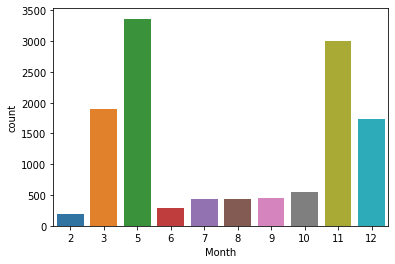

In [20]:
sns.countplot(data["Month"])

### OperatingSystems

In [21]:
data.OperatingSystems.value_counts()

2    6593
1    2582
3    2552
4     478
8      79
6      19
7       7
5       6
Name: OperatingSystems, dtype: int64

En este caso, podemos agrupar los valores en 4 niveles: tres para los tres primeros niveles, que son los más importantes en cuanto a presencia, y uno para el resto.

In [22]:
data.loc[(data["OperatingSystems"] != 1) & 
         (data["OperatingSystems"] != 2) & 
         (data["OperatingSystems"]!= 3), "OperatingSystems"] = 4

In [23]:
data.OperatingSystems.value_counts()

2    6593
1    2582
3    2552
4     589
Name: OperatingSystems, dtype: int64

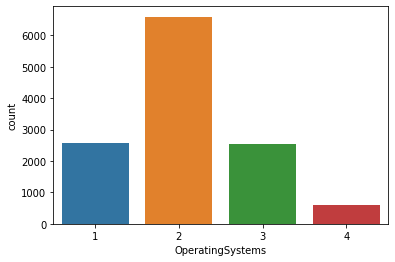

In [24]:
sns.countplot(data["OperatingSystems"])

### Browser

In [25]:
data.Browser.value_counts()

2     7951
1     2459
4      735
5      467
6      174
10     163
8      135
3      105
13      61
7       49
12      10
11       6
9        1
Name: Browser, dtype: int64

De forma similar a la anterior, dejaremos 3 niveles, englobando todos los valores que no sean del tipo 1 y 2.

In [26]:
data.loc[(data["Browser"]!= 1) & (data["Browser"]!= 2), "Browser"] = 3

In [27]:
data.Browser.value_counts()

2    7951
1    2459
3    1906
Name: Browser, dtype: int64

### Region

In [28]:
 data.Region.value_counts()

1    4774
3    2402
4    1179
2    1134
6     804
7     761
9     511
8     434
5     317
Name: Region, dtype: int64

A Region simplemente le aplicamos LabelEncoder() aunque los valores originales nos podrían servir. No es una variable ordenada,
y, aunque hay 4 regiones destacadas, no queremos dejar ninguna sin representar de forma específica.

In [29]:
data.Region= le.fit_transform(data.Region.values)

In [30]:
data.Region.value_counts()

0    4774
2    2402
3    1179
1    1134
5     804
6     761
8     511
7     434
4     317
Name: Region, dtype: int64

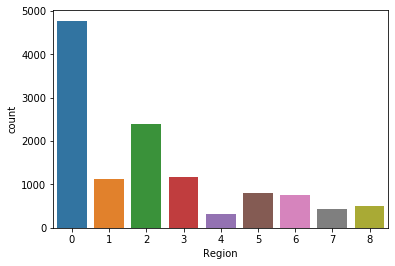

In [31]:
sns.countplot(data["Region"])

### TrafficType

In [32]:
data.TrafficType.value_counts()

2     3909
1     2444
3     2051
4     1069
13     737
10     450
6      444
8      343
5      260
11     247
20     198
9       42
7       40
15      37
19      17
14      13
18      10
16       3
12       1
17       1
Name: TrafficType, dtype: int64

El tipo de tráfico lo vamos a resumir en 5 niveles; los 4 más representativos y el resto.

In [33]:
data.loc[(data["TrafficType"] != 1) & 
         (data["TrafficType"] != 2) & 
         (data["TrafficType"] != 3) & 
         (data["TrafficType"] != 4), "TrafficType"] = 5

In [34]:
data.TrafficType.value_counts()

2    3909
5    2843
1    2444
3    2051
4    1069
Name: TrafficType, dtype: int64

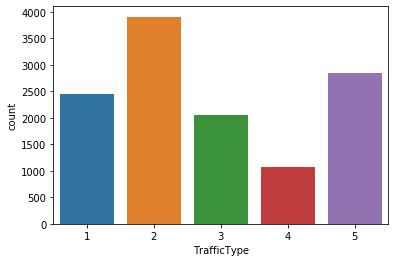

In [35]:
sns.countplot(data["TrafficType"])

### VisitorType

In [36]:
data["VisitorType"].value_counts()

Returning_Visitor    10537
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

En esta variable es claramente superior el nivel de los visitantes que regresan. Diferenciaremos este nivel del resto.

In [37]:
data.loc[data["VisitorType"]!= "Returning_Visitor", "VisitorType"] = 0
data.loc[data["VisitorType"]== "Returning_Visitor", "VisitorType"] = 1
data.VisitorType = data.VisitorType.astype(int)

In [38]:
data.VisitorType.value_counts()

1    10537
0     1779
Name: VisitorType, dtype: int64

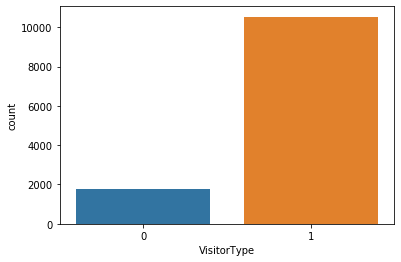

In [39]:
sns.countplot(data["VisitorType"])

### Weekend

In [40]:
data.Weekend.value_counts()

False    9451
True     2865
Name: Weekend, dtype: int64

Codificamos con LabelEncoder, no es variable ordenada.

In [41]:
data["Weekend"] = le.fit_transform(data.Weekend.values)

In [42]:
data["Weekend"].value_counts()

0    9451
1    2865
Name: Weekend, dtype: int64

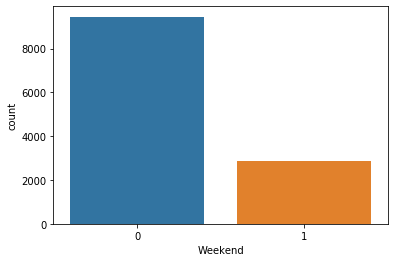

In [43]:
sns.countplot(data["Weekend"])

### Revenue

In [44]:
data.Revenue.value_counts()

False    10408
True      1908
Name: Revenue, dtype: int64

Esta va a ser nuestra variable objetivo. Vamos a codificar las ventas como 1, y vamos a cambiar el nombre de la variable definiendola como nuestra target.

In [45]:
data["Revenue"].map({"False":0, "True":1})

data["Target"] = data.Revenue.astype(int)

In [46]:
data.Target.value_counts()

0    10408
1     1908
Name: Target, dtype: int64

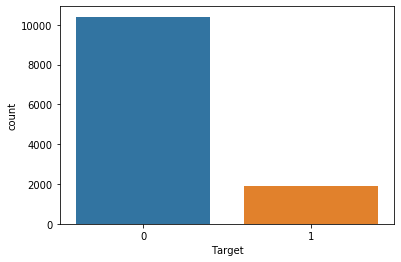

In [47]:
sns.countplot(data["Target"])

Ahora podemos prescindir de la variable original.

In [48]:
data.drop('Revenue', axis=1, inplace=True) 

# Con el parámetro inplace=True, realizamos la operación guardando la modificación sin mostrar el resultado.

In [49]:
data[:3]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Target
0,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.2,0.0,0.0,2,1,1,0,1,1,0,0
1,0.0,0.0,0.0,0.0,2.0,64.0,0.0,0.1,0.0,0.0,2,2,2,0,2,1,0,0
2,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.2,0.0,0.0,2,4,1,8,3,1,0,0


## Comprobación tipos no numéricos:

Ya no quedan variables que no sean numéricas.

In [50]:
data.select_dtypes(exclude=["number"]).columns

Index([], dtype='object')

## Division en features X + target Y

A continuación divido los datos en **X** (variables independientes o predictoras) e **Y** (variable dependiente,  a predecir), y podemos definir al conjunto completo con todas sus variables ya pasadas a numéricas, como __XY__.

In [51]:
XY = data
X = data.drop('Target', axis=1)
Y = data['Target']

In [52]:
XY.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Target
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,2,1,1,0,1,1,0,0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,2,2,2,0,2,1,0,0
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,2,4,1,8,3,1,0,0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,2,3,2,1,4,1,0,0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,2,3,3,0,4,1,1,0


# Visualización y correlaciones

## Descriptivos básicos:

Con la función describe(), aprovechando que ya tenemos todos los datos transformados a tipo numérico, podemos obtener los 
estadísticos básicos: conteo total de observaciones, media, desviación típica, mínimo, máximo, y cuartiles, incluyendo la mediana (percentil 50%).

In [53]:
XY.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Target
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.895952,0.061497,7.657113,2.093212,1.955099,2.148019,2.834199,0.855554,0.232624,0.154920
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.577926,0.199020,3.391314,0.774282,0.593658,2.402211,1.447061,0.351556,0.422522,0.361844
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,5.000000,2.000000,2.000000,0.000000,2.000000,1.000000,0.000000,0.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,7.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,11.000000,3.000000,2.000000,3.000000,4.000000,1.000000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,12.000000,4.000000,3.000000,8.000000,5.000000,1.000000,1.000000,1.000000


Esta vista estadística general nos permite darnos cuenta de la diferencia de rangos entre unas variables y otras. Por ejemplo, _Administrative_ abarca un rango de 0 a 27, mientras que _ProductRelated_Duration_ de -1 a 63973. Esta diferencia se acentúa más cuando las comparamos con los rangos de las variables categóricas. Lo que esto implica es, que antes de introducir estos valores al modelo a entrenar, vamos a tener que estandarizarlos, para que se muevan en una escala similar, evitando de esta manera que unas variables tengan más peso que otras por manejar rangos más amplios. 

Otro aspecto que podemos analizar, es que la mayoría de las variables tienen una media superior a su valor mediano (algunas bastante alejadas, como _Administrative_Duration_ ), lo que significa que las distribuciones van a tener sesgo, asimetría hacia la derecha, por tanto, es otro motivo por el que estandarizar, ya que las distribuciones no van a ser normales. 

Con esta estandarización, además, conseguimos mejorar las visualizaciones al tener los datos centrados en torno a rangos muy similares.

Como último aspecto, nos puede llamar la atención que, en las variables que miden tiempo, encontremos valores negativos. Como no sabemos cuál es el motivo o si se trata de un error, las dejaremos sin modificar.

## Boxplots:

Al efecto de lo explicado anteriormente, normalizaremos el conjunto X. 

In [54]:
X_normalizado = (X-X.mean())/X.std()

In [55]:
X_normalizado[:3]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,-0.697553,-0.457458,-0.396615,-0.245029,-0.691473,-0.624767,3.672477,3.235240,-0.317363,-0.309001,-1.668118,-1.411905,-1.608838,-0.894184,-1.267534,0.410877,-0.550561
1,-0.697553,-0.457458,-0.396615,-0.245029,-0.668997,-0.591336,-0.457439,1.174544,-0.317363,-0.309001,-1.668118,-0.120385,0.075634,-0.894184,-0.576478,0.410877,-0.550561
2,-0.697553,-0.463112,-0.396615,-0.252130,-0.691473,-0.625290,3.672477,3.235240,-0.317363,-0.309001,-1.668118,2.462654,-1.608838,2.436081,0.114577,0.410877,-0.550561


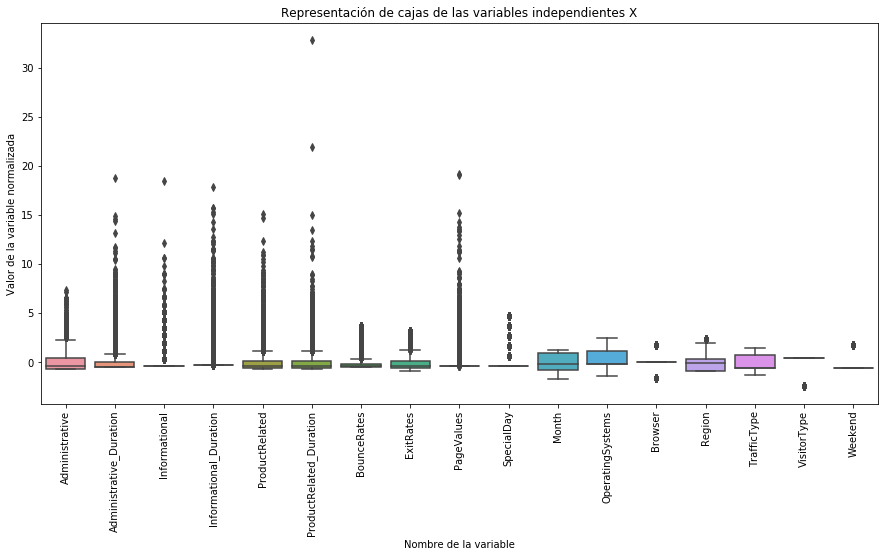

In [56]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

A pesar de haber normalizado, existe presencia de outliers que deberemos tratar.

Otra opción para estandarizar, es hacer uso de StandardScaler()  de la librería sklearn, que emplearemos más adelante.

## Histogramas

Mostramos los histogramas con las distintas distribuciones, comprobando la asimetría hacia la derecha que anticipábamos en las variables cuantitativas continuas.

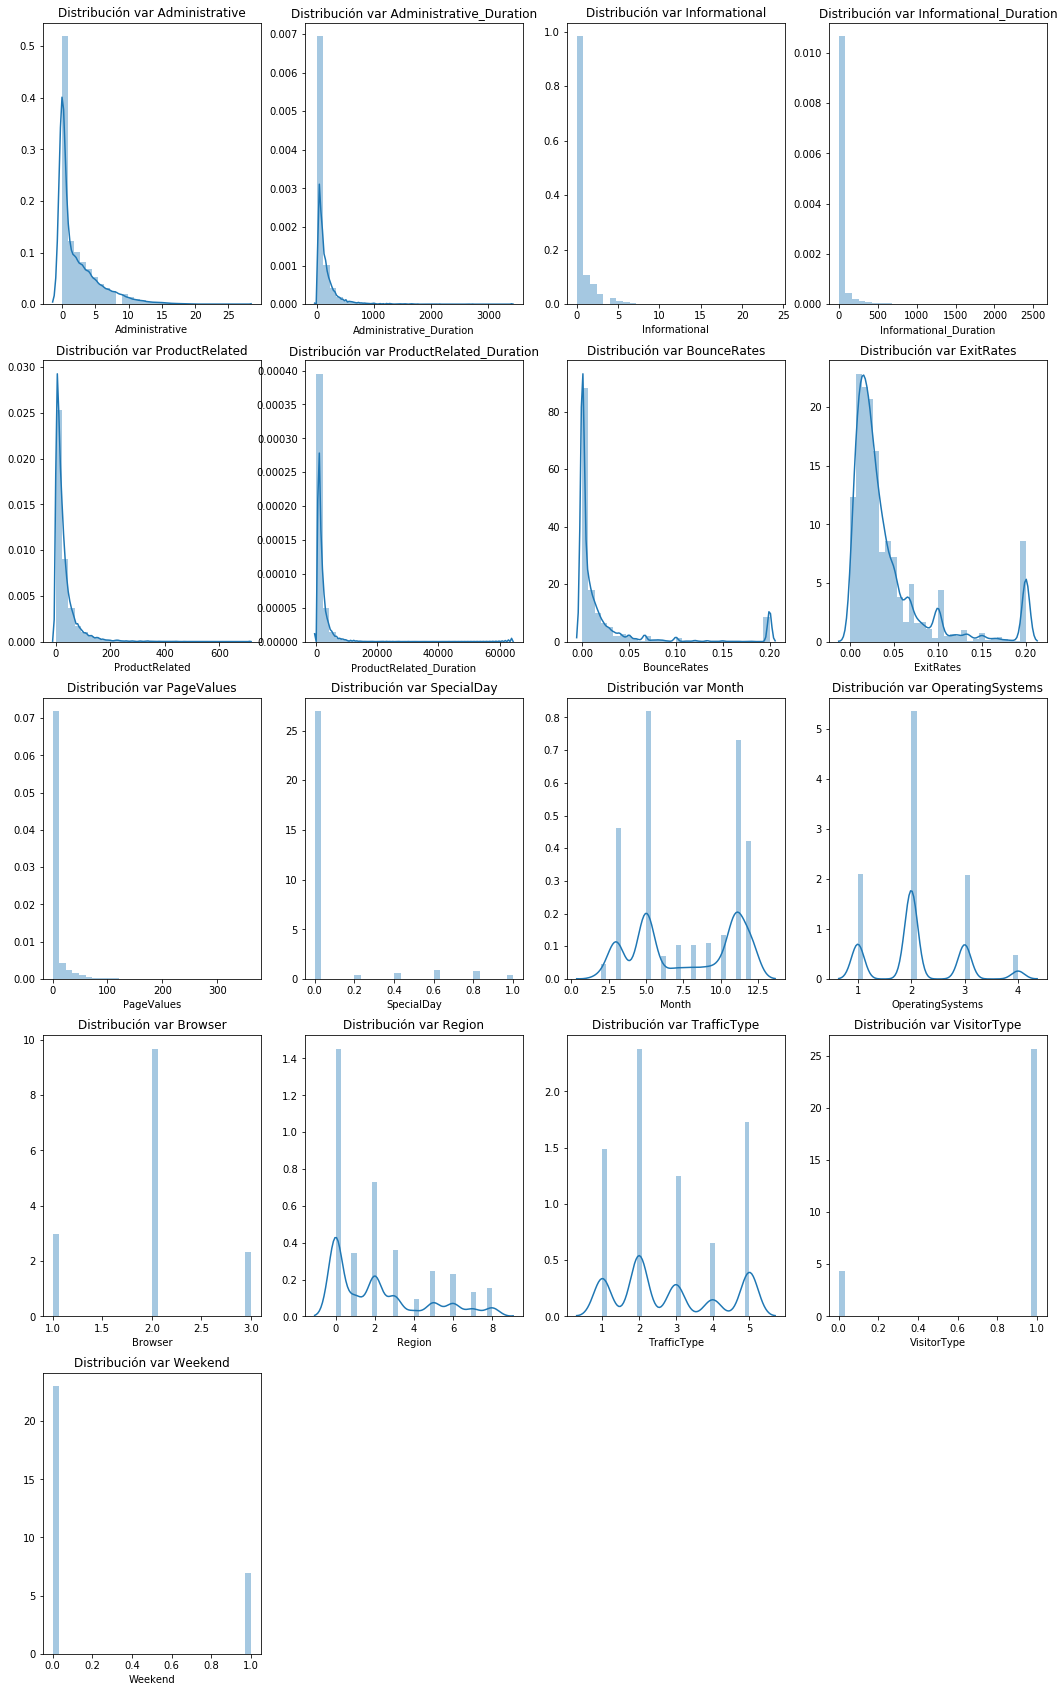

In [57]:
plt.figure(figsize=(18,30))
n = 0
for i, column in enumerate(X.columns):
    n+=1
    plt.subplot(5, 4, n)
    sns.distplot(X[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

## Relación variable vs target:

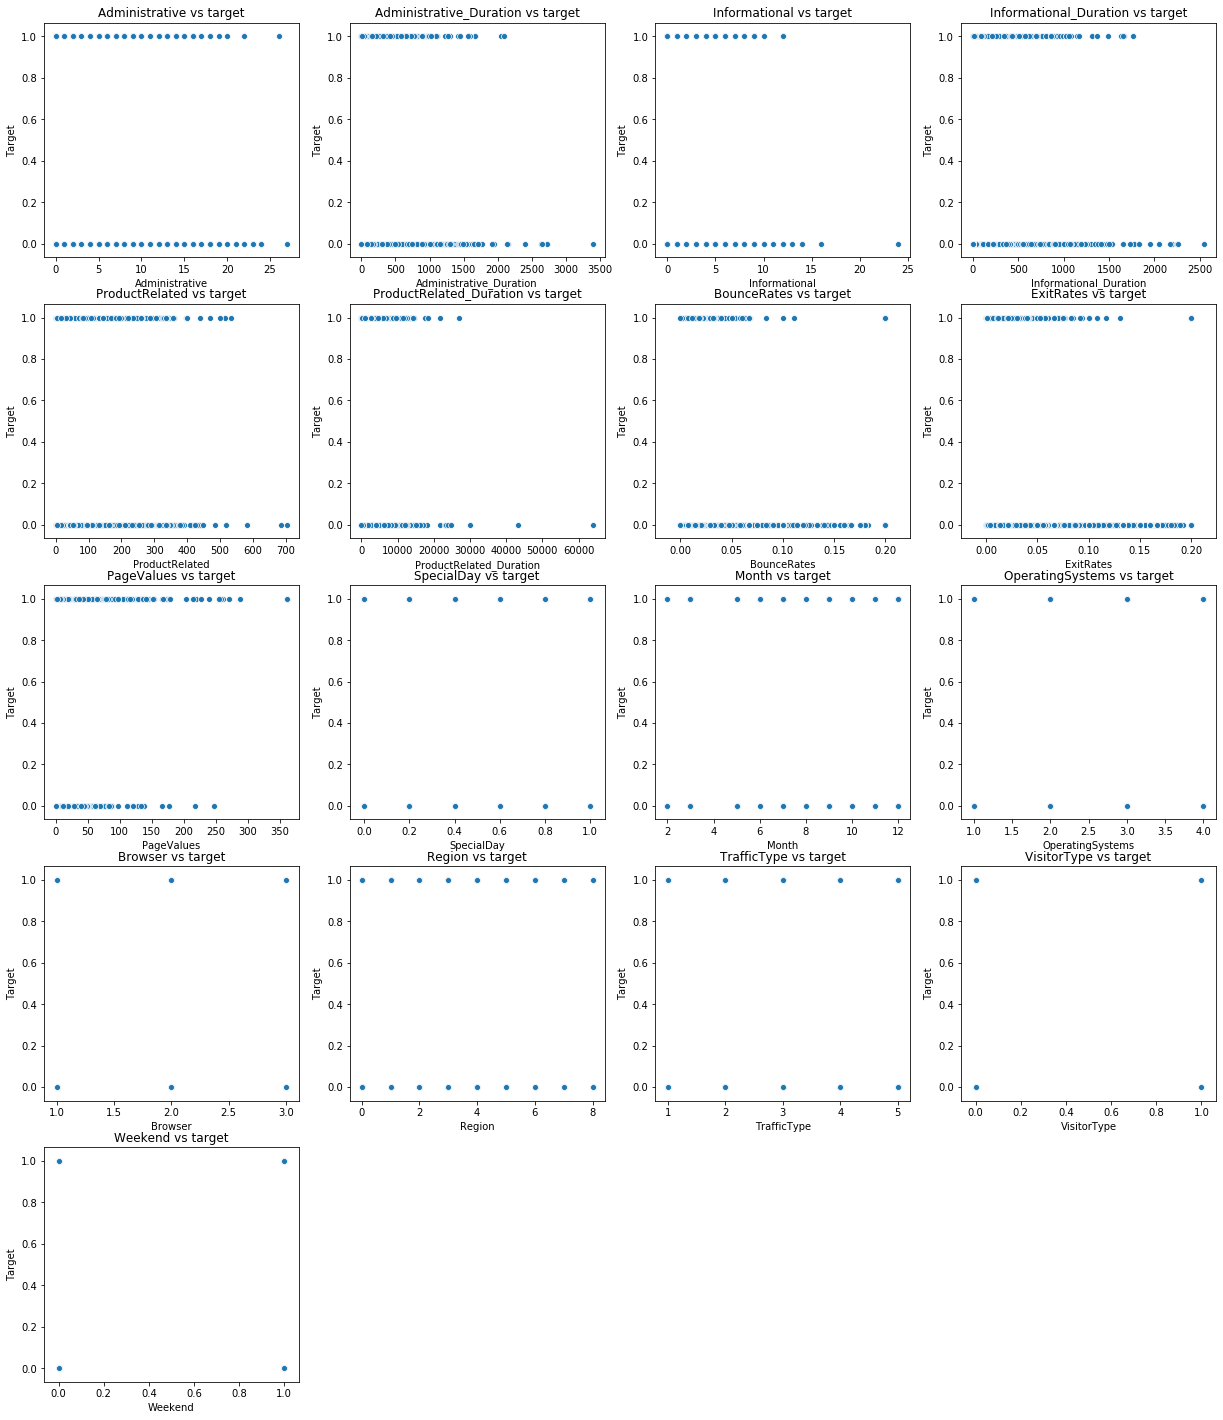

In [58]:
relaciones_vs_target(X, Y)

En esta representación de relación entre X e Y podemos ver algunas tendencias en las variables cuantitativas continuas. 
Por ejemplo, las visitas que terminan en venta, registran valores máximos en la duración mas bajos que cuando no hay venta. Es decir, a partir de cierta duración, las probabilidades de compra caen significativamente.

Igualmente ocurre con _BounceRate_ y _ExitRate_ , menor capacidad para retener a los visitantes lógicamente significan menos ventas.

La variable _PageValues_ lo que nos indica es que a mayor valor medio de la página web, más ventas, es decir la calidad de la página influye.

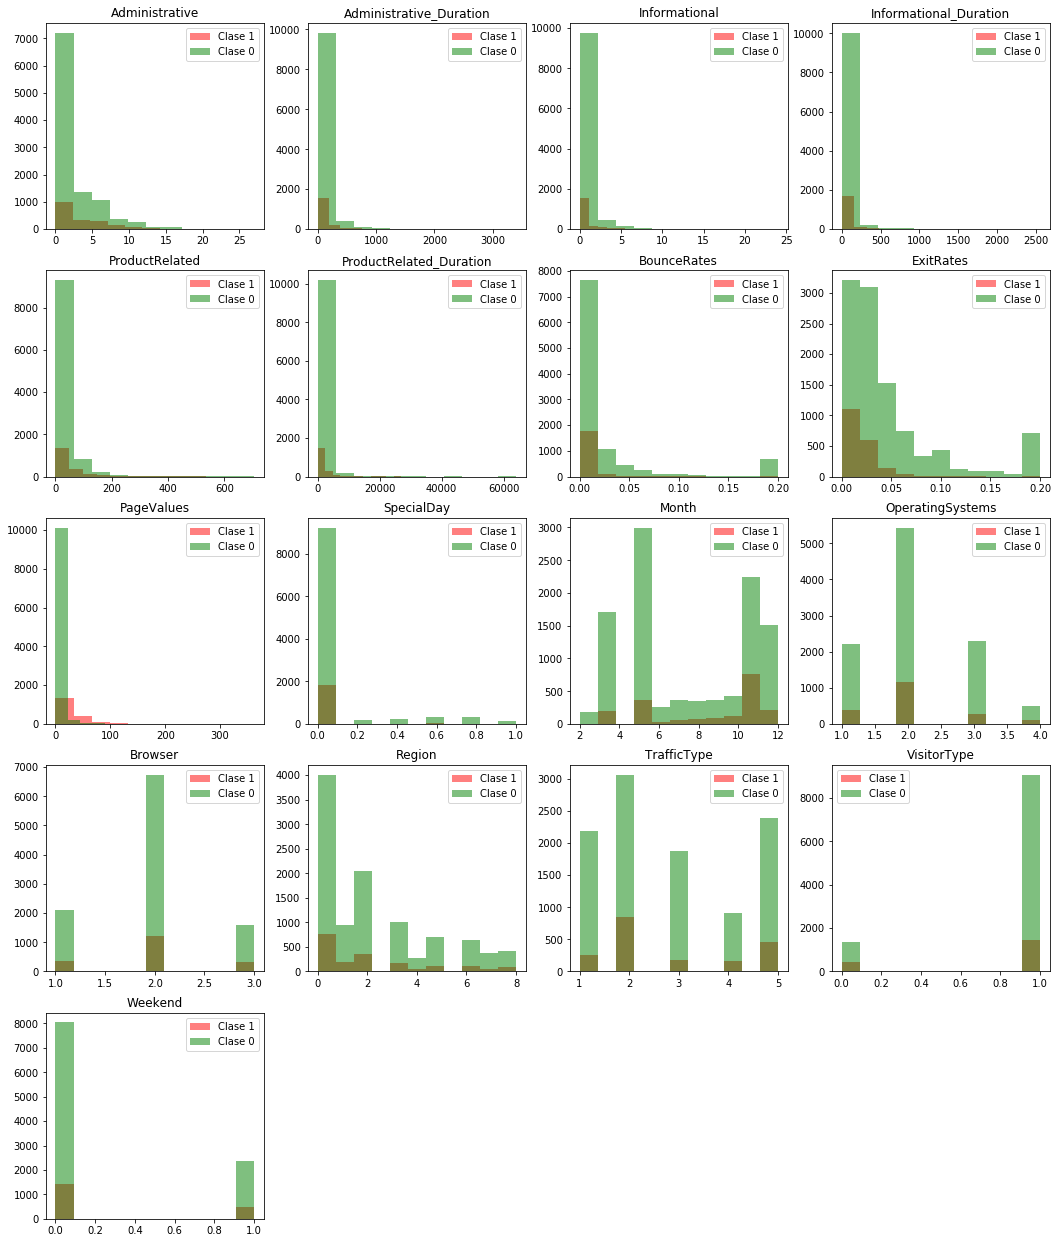

In [59]:
hist_pos_neg_feat(X, Y)

Aquí podemos observar las distintas distribuciones diferenciadas en función de la "Target", es decir, si hay venta o no. Podemos confirmar lo que hemos analizado en el punto anterior, y además añadir:

   + _SpecialDay_ tiene claramente más ventas los días especiales. 
   
   + El mes con más ventas es Noviembre, aunque no es el que tiene más visitas. 
   
   + El sistema operativo, navegador, y tipo de tráfico con más ventas, es el tipo 2.
   
   + Las regiones más interesantes con las tres primeras.
   
   + Tenemos más ventas en clientes que regresan que en clientes nuevos, aunque la proporción de éxito es mejor en clientes nuevos.
   
   + Se vende más entre semana que en fin de semana, aunque también la actividad de la página entre semana es mayor.

In [60]:
returning_visitor_sell = XY.loc[(XY["VisitorType"] == 1) & (XY["Target"]==1), "VisitorType"].count() 

total_returning_visitor = XY.loc[(XY["VisitorType"] == 1), "VisitorType"].count()

print("El porcentaje de venta sobre visitantes que regresan es %.2f"% ((returning_visitor_sell / total_returning_visitor)*100))



new_visitor_sell = XY.loc[(XY["VisitorType"] == 0) & (XY["Target"]==1), "VisitorType"].count()

total_new_visitor = XY.loc[(XY["VisitorType"] == 0), "VisitorType"].count()

print("El porcentaje de venta sobre visitantes nuevos es %.2f "% ((new_visitor_sell / total_new_visitor)*100))

El porcentaje de venta sobre visitantes que regresan es 13.95
El porcentaje de venta sobre visitantes nuevos es 24.62 


In [61]:
weekend_sell = XY.loc[(XY["Weekend"] == 1) & (XY["Target"]==1), "Weekend"].count() 

total_weekend = XY.loc[(XY["Weekend"] == 1), "Weekend"].count()

print("El porcentaje de venta en fin de semana es %.2f"% ((weekend_sell / total_weekend)*100))



no_weekend_but_sell = XY.loc[(XY["Weekend"] == 0) & (XY["Target"]==1), "Weekend"].count() 

total_no_weekend = XY.loc[(XY["Weekend"]== 0), "Weekend"].count()

print("El porcentaje de venta entre semana es %.2f"% ((no_weekend_but_sell / total_no_weekend)*100))

El porcentaje de venta en fin de semana es 17.42
El porcentaje de venta entre semana es 14.91


## Matriz de correlaciones

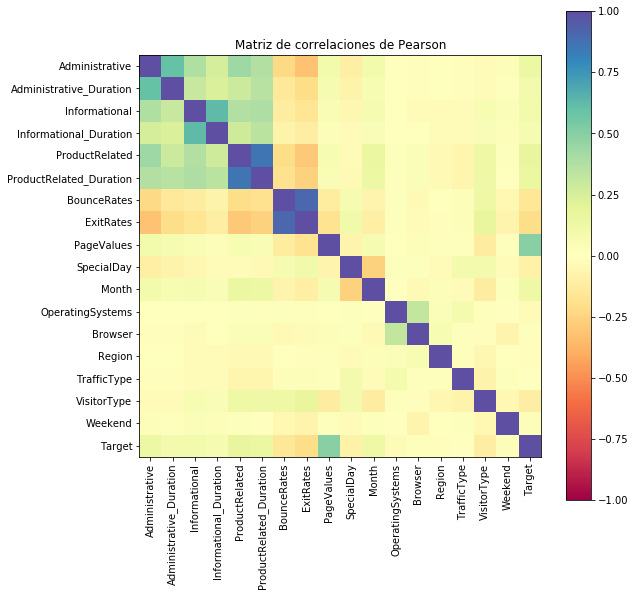

In [62]:
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Spectral')))
_ = plt.title('Matriz de correlaciones de Pearson')

En esta matriz encontramos que _ProductRelated_ y _ProductRelated_Duration_ están muy correlacionadas. Lo mismo ocurre entre _ExitRates_ y _BounceRates_ . Cuando esto ocurre debemos eliminar una de cada alta correlación, pues a efectos del modelado no nos aportan información adicional. Aunque a un nivel más bajo que en las anteriores, también detectamos correlación entre _Administrative_Duration_ con _Administrative_ ,  y  _Informational_Duration_ con _Informational_.

Para decidir cuál conservamos, consultaremos las variables con mayor correlación con la Target.

## Variables con mayor correlación con la target:

In [63]:
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
PageValues,0.492494
ExitRates,-0.206886
ProductRelated,0.158280
ProductRelated_Duration,0.152130
BounceRates,-0.150621
Administrative,0.138631
Month,0.126868
VisitorType,-0.103664
Informational,0.095085
Administrative_Duration,0.093395


En este caso, conservaremos _ProductRelated_ ,  _ExitRates_ , _Administrative_ , y _Informational_ porque tienen mayor correlación con la Target, por lo que nos pueden ayudar a predecir mejor. Eliminamos por ello _ProductRelated_Duration_ ,   _BounceRates_ , _Administrative_Duration_ y _Informational_Duration_ .

In [64]:
len(X.columns)

17

In [65]:
X = X.drop(["ProductRelated_Duration","BounceRates", "Administrative_Duration", "Informational_Duration"], axis=1)

In [66]:
len(X.columns)

13

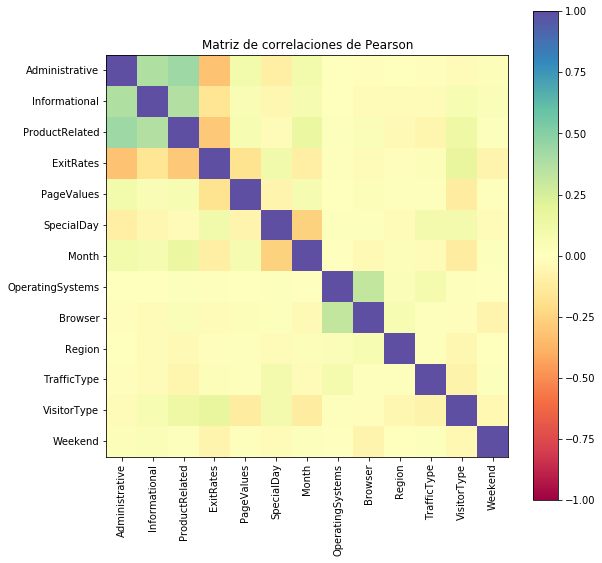

In [67]:
matriz_correlaciones = X.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), X.columns, rotation='vertical')
plt.yticks(range(n_ticks), X.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Spectral')))
_ = plt.title('Matriz de correlaciones de Pearson')

## Estandarización de los datos previa:

Como hemos comentado anteriormente, debemos estandarizar los datos antes de entrenar el modelo para centrarlos en torno a la misma escala de valores.

In [68]:
obj_escalar = StandardScaler()  # nos devuelve un array
X_estandarizado = obj_escalar.fit_transform(X)

## Tratamiento de outliers:

Volvemos al tratamiento de outliers, para ello utilizaremos los datos estandarizados que hemos obtenido con StandardScaler().

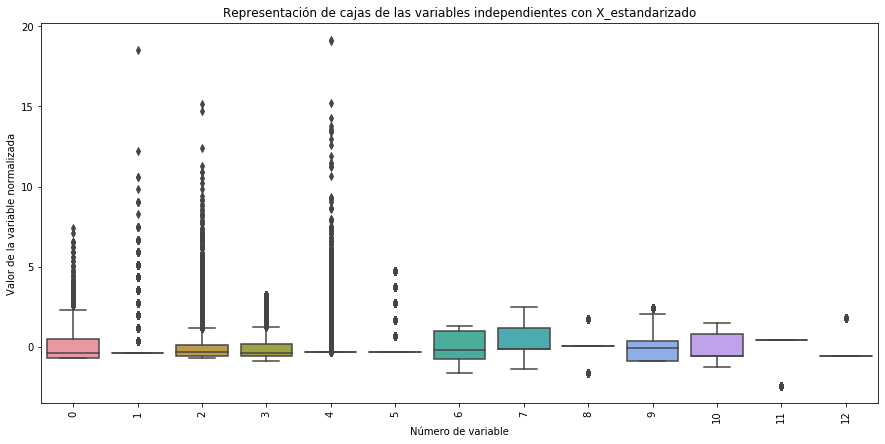

In [69]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_estandarizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes con X_estandarizado')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Número de variable')

In [70]:
# Lo transformamos a Dataframe y creamos una copia para conservar X_estandarizado con outliers

X_estandarizado_df = pd.DataFrame(X_estandarizado, columns=X.columns).copy()

X_estandarizado_df[:2]

,Administrative,Informational,ProductRelated,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,-0.697582,-0.396631,-0.691501,3.235371,-0.317376,-0.309014,-1.668186,-1.411962,-1.608903,-0.89422,-1.267586,0.410894,-0.550584
1,-0.697582,-0.396631,-0.669024,1.174592,-0.317376,-0.309014,-1.668186,-0.120390,0.075637,-0.89422,-0.576502,0.410894,-0.550584


En este caso sustituyo los outliers por los límites inferiores (Q1-1.5 IQR) y superiores (Q3+1.5 IQR)

In [71]:
for k in list(X_estandarizado_df.columns):
    IQR = np.percentile(X_estandarizado_df[k],75) - np.percentile(X_estandarizado_df[k],25)
    
    limite_superior = np.percentile(X_estandarizado_df[k],75) + 1.5*IQR
    limite_inferior = np.percentile(X_estandarizado_df[k],25) - 1.5*IQR
    
    X_estandarizado_df[k] = np.where(X_estandarizado_df[k] > limite_superior,limite_superior,X_estandarizado_df[k])
    X_estandarizado_df[k] = np.where(X_estandarizado_df[k] < limite_inferior,limite_inferior,X_estandarizado_df[k])
    
X_estandarizado_no_outliers = X_estandarizado_df

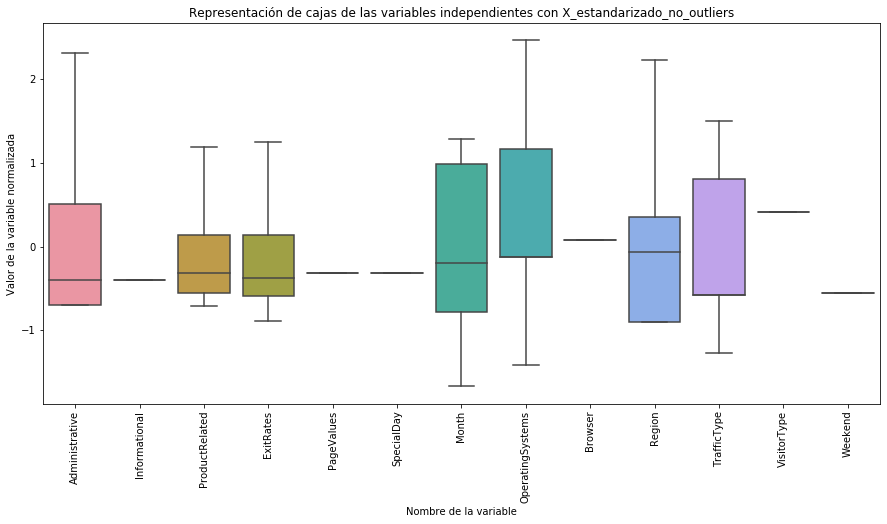

In [72]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_estandarizado_no_outliers)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes con X_estandarizado_no_outliers')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

Llegado este punto, tenemos 2 conjuntos para entrenar al modelo: uno con outliers (X_estandarizado) y otro sin outliers (X_estandarizado_no_outliers)

Tras probar, averiguamos que conseguimos mejores métricas utilizando el conjunto con outliers. El motivo puede deberse a que, al sustituir outliers por los límites de los bigotes, hay variables que pierden todo su rango de valores(ej _Informational_ , _PageValues_ , _SpecialDay_ ) lo que supone una pérdida de información valiosa, y por tanto no podamos aprovecharlas para predecir.

In [73]:
X_estandarizado_no_outliers.describe()

,Administrative,Informational,ProductRelated,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
count,12316.000000,1.231600e+04,12316.000000,12316.000000,1.231600e+04,1.231600e+04,1.231600e+04,1.231600e+04,1.231600e+04,12316.000000,1.231600e+04,1.231600e+04,1.231600e+04
mean,-0.035067,-3.966306e-01,-0.113309,-0.135882,-3.173762e-01,-3.090136e-01,2.718756e-14,2.217561e-17,7.563746e-02,-0.008636,-6.416009e-15,4.108937e-01,-5.505838e-01
std,0.880436,9.881386e-15,0.565488,0.628335,8.016136e-14,3.641679e-14,1.000041e+00,1.000041e+00,1.528006e-14,0.979654,1.000041e+00,6.661609e-14,1.424474e-13
min,-0.697582,-3.966306e-01,-0.713979,-0.886187,-3.173762e-01,-3.090136e-01,-1.668186e+00,-1.411962e+00,7.563746e-02,-0.894220,-1.267586e+00,4.108937e-01,-5.505838e-01
25%,-0.697582,-3.966306e-01,-0.556635,-0.591790,-3.173762e-01,-3.090136e-01,-7.835371e-01,-1.203901e-01,7.563746e-02,-0.894220,-5.765018e-01,4.108937e-01,-5.505838e-01
50%,-0.396614,-3.966306e-01,-0.309380,-0.368427,-3.173762e-01,-3.090136e-01,-1.937713e-01,-1.203901e-01,7.563746e-02,-0.061620,-5.765018e-01,4.108937e-01,-5.505838e-01
75%,0.506288,-3.966306e-01,0.140174,0.144202,-3.173762e-01,-3.090136e-01,9.857603e-01,1.171182e+00,7.563746e-02,0.354680,8.056660e-01,4.108937e-01,-5.505838e-01
max,2.312092,-3.966306e-01,1.185387,1.248191,-3.173762e-01,-3.090136e-01,1.280643e+00,2.462754e+00,7.563746e-02,2.228030,1.496750e+00,4.108937e-01,-5.505838e-01


Por ello continuaremos el ejercicio con X_estandarizado, que contiene outliers.

## División en train y test:

A continuación separamos tanto X como Y en dos subconjuntos, uno para entrenar y otro para validar. 
El conjunto de test NUNCA se usa para ajustar los modelos. Es un conjunto que se separa y se valida al final del todo para obtener una métrica.


In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)

# configuramos que el tamaño del conjunto de test sea un 20%, por tanto el conjunto de entrenamioento será el 80% de los datos

## 1er modelo:  regresión logística
### Aplicamos un modelo de clasificación lineal
### Optimizando C y class_weight con GridSearch

In [75]:
modelo = LogisticRegression()
parametros = {"C": [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.09], 
              "class_weight":['balanced', None]}

Con GridSearchCV se realiza una optimización. Esta función lo que hace es ajustar el modelo que se pasa como argumento con todas las combinaciones posibles de los parámetros. En este caso, todas las combinaciones de C y class_weights.

In [76]:
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09],
                         'class_weight': ['balanced', None]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [77]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'C': 0.09, 'class_weight': 'balanced'} 
ROC AUC: 0.9


La mejor combinación de parámetros consiste en  'C': 0.09 y  'class_weight': 'balanced', resultando un área bajo la curva ROC de **0.90**.

In [78]:
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

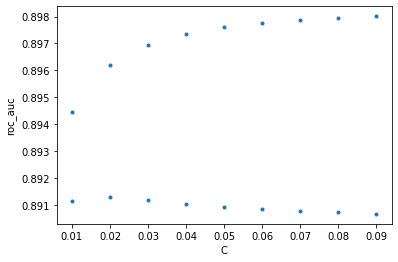

In [79]:
plt.xlabel('C')
plt.ylabel('roc_auc')
_ = plt.plot( df_search['param_C'], df_search['mean_test_score'], '.')

# representamos la curva ROC en función de la C, comprobamos que la mejor C es 0.09

#### Analizando el modelo con el mejor alpha
En este paso nos quedamos con los mejores parámetros obtenidos en el paso anterior:

In [80]:
reg_log =  LogisticRegression(C=modelo_gs.best_params_['C'],
                              class_weight=modelo_gs.best_params_['class_weight'])

Ajusto a todos los datos de entrenamiento.

In [81]:
reg_log.fit(X_train, Y_train)

LogisticRegression(C=0.09, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Aquí es cuando entra en juego el conjunto de Test. Cuando se quiere validar un modelo ya elegido y optimizado.

Con ese modelo optimizado, predigo test para ver cómo se comporta en datos que no ha visto antes.

El modelo de regresión logística permite devolver probabilidades de cada clase (predict_proba) o la predicción de
la clase como tal (predict). Suponiendo que una clase tenga Y=0 y la otra Y=1, puede devolver las probabilidades
(probY0, probY1) o la predicción (Y0 o Y1).

In [82]:
y_test_pred_prob = reg_log.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

In [83]:
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

0.8926731780386403

La métrica ROC de la predicción en Test, tras optimizar parámetros y ajustar al conjunto de entrenamiento, es **0.89**

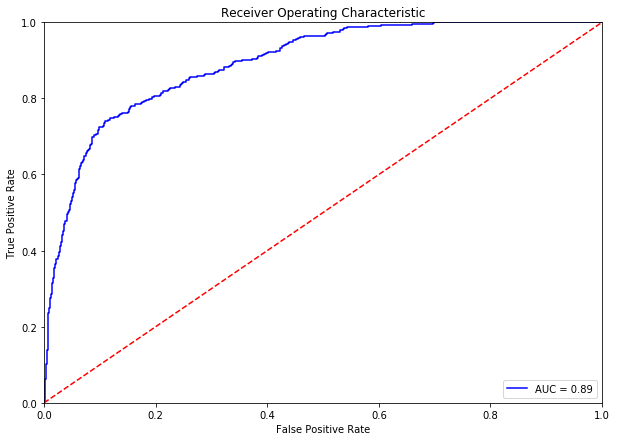

In [84]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Representamos la curva ROC de nuestro modelo entrenado y optimizado. El área bajo la curva es de 0.89.
Recordemos que el área bajo la curva ROC tiene valores que van de 0 a 1, siendo 0,5 un clasificador aleatorio, 1 un clasificador perfecto y 0 un clasificador que en todos los casos da el resultado erróneo.

La siguiente figura representa en verde las probabilidades que asigna el modelo a los datos que son 0s (cuanto más cerca de 0 la distribución verde mejor) y en rojo las probabilidades asignadas a los datos que son 1s (cuanto más cerca esté de 1 la distribución roja mejor).

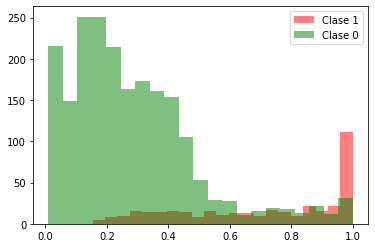

In [85]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

### Umbralizo las predicciones:

Las probabilidades que devuelve el modelo son valores continuos entre 0 y 1. Para pasarlo a 0s y a 1s es necesario usar un umbral de corte. Todo lo que sea mayor que el umbral será predicción = 1, y lo que sea menor será predicción = 0.

In [86]:
umbral = 0.5
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)

In [87]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))   

Matriz de confusión
 [[1860  228]
 [  99  277]]

Accuracy	0.87
Sensitividad	0.74
Precisión	0.55


+ **True Positive**: 1860 visitas de los cuáles hemos predicho que se produce venta y finalmente se produce.
+ **False Negative**: 99 visitas de los cuáles hemos predicho que no se produce venta pero finalmente se produce. (Error tipo II).
+ **False Positive**: 228 visitas de los cuáles hemos predicho que se produce venta y finalmente no se produce(Error tipo I)
+ **True Negative**: 277 visitas de los cuáles hemos predicho que no se produce venta y finalmente no se produce.

Recordemos:

+ **Exactitud (accuracy)** es el total de casos identificados correctamente (verdaderos positivos más verdaderos
negativos) entre el total de casos.


+ **Sensibilidad (sensitivity, recall)** es el número de verdaderos positivos entre el total de positivos (o sea, entre la
suma de verdaderos positivos y falsos negativos). También se conoce como “tasa de verdaderos positivos”.


+ **Precisión (precision)** es el número de verdaderos positivos entre el total de casos predichos como positivos
(verdaderos positivos más falsos positivos).

A medida que subimos el umbral, más seguros estamos de acertar las predicciones de venta ( más alta es la Precision), pero a cambio, hay más ventas que se producen que no hemos predicho (baja la Sensitividad), y viceversa.

Si tenemos que elegir un umbral que maximice el área bajo la curva ROC, nos podemos servir del histograma de probabilidades, y ver que hasta 0.5, la probabilidades de asignar a un valor la clase 0 y acertar son mucho más altas. A partir de 0.5 se equilibran, y a partir de 0.6 empieza a ser más probable acertar cuando asignemos la clase 1.

Si probamos con varios umbrales, comprobamos que el mayor AUC ROC (**0.81**) se consigue con el umbral por defecto, 0.5.

In [88]:
metrics.roc_auc_score(Y_test, y_umbralizadas)

0.8137533626803619

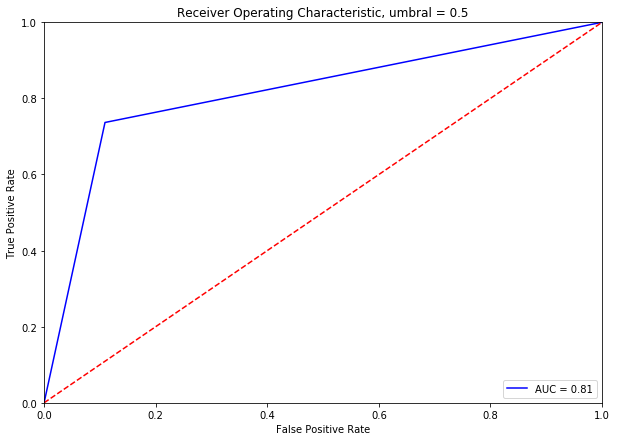

In [89]:
preds = y_umbralizadas
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic, umbral = '+str(umbral))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2º modelo: K-nearest neighbors (KNN)

### Modelo de clasificación no lineal

In [90]:
clf = KNeighborsRegressor()

Buscamos optimizar el parámetro de nº de vecinos para maximizar la métrica "roc_auc", probando con un rango de 1 a 30 vecinos.

In [91]:
params = {"n_neighbors": range(1,30)} 

clf_gs = GridSearchCV(clf, params, cv= 5, scoring= "roc_auc")

In [92]:
clf_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 30)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='roc_auc',
             verbose=0)

In [93]:
print(clf_gs.best_params_, "\nROC AUC: {}".format(round(clf_gs.best_score_,2)))

{'n_neighbors': 29} 
ROC AUC: 0.85


In [94]:
df_search = pd.DataFrame.from_dict(clf_gs.cv_results_)

In [95]:
df_search[:2]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.092662,0.004761,0.211541,0.017013,1,{'n_neighbors': 1},0.699622,0.671338,0.667356,0.670783,0.683485,0.678517,0.011883,29
1,0.091060,0.005063,0.240160,0.006787,2,{'n_neighbors': 2},0.756827,0.718955,0.721305,0.722301,0.745880,0.733053,0.015376,28


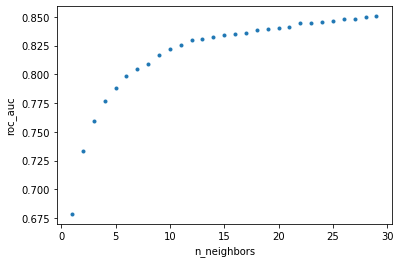

In [96]:
plt.xlabel('n_neighbors')
plt.ylabel('roc_auc')
_ = plt.plot( df_search['param_n_neighbors'], df_search['mean_test_score'], '.')

Una vez optimizado con GridSearch, nos quedamos con los mejores parámetros.

In [97]:
kneigh =  KNeighborsRegressor(n_neighbors = clf_gs.best_params_['n_neighbors'])

Volvemos a ajustar al conjunto de entrenamiento.

In [98]:
kneigh.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                    weights='uniform')

Obtenemos las predicciones.

In [99]:
y_test_pred = kneigh.predict(X_test)
y_test_pred_pos = y_test_pred[np.where(Y_test == 1)[0]]
y_test_pred_neg = y_test_pred[np.where(Y_test == 0)[0]]

In [100]:
round(roc_auc_score(Y_test, y_test_pred),2)

0.85

La métrica AUC ROC de la predicción en Test, tras optimizar parámetros y ajustar al conjunto de entrenamiento, es **0.85**

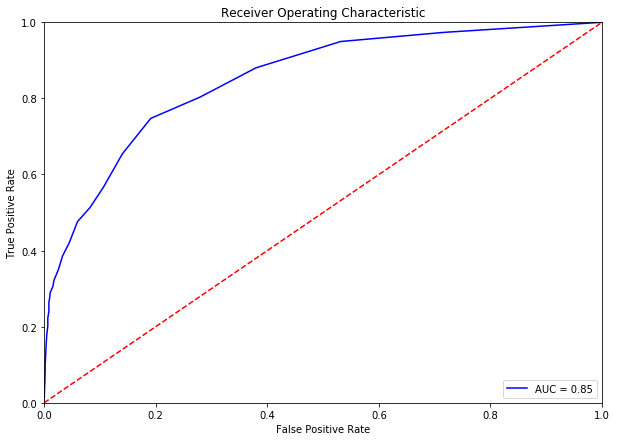

In [101]:
preds = y_test_pred
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

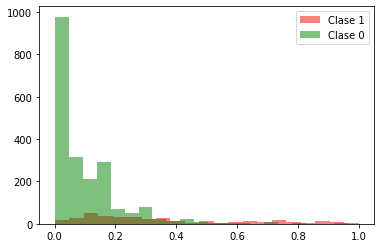

In [102]:
represento_doble_hist(y_test_pred_pos, y_test_pred_neg, n_bins=21, density=0)

A la hora de umbralizar, para maximizar el área obtenida bajo la curva ROC, y tras probar con diversos umbrales, lo conseguimos con un umbral 0.2, que nos genera un AUC ROC de **0.76** 

In [103]:
umbral = 0.2
y_umbralizadas = 1*(y_test_pred > umbral)

In [104]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))    

Matriz de confusión
 [[1795  293]
 [ 130  246]]

Accuracy	0.83
Sensitividad	0.65
Precisión	0.46


In [105]:
round(roc_auc_score(Y_test, y_umbralizadas),2)

0.76

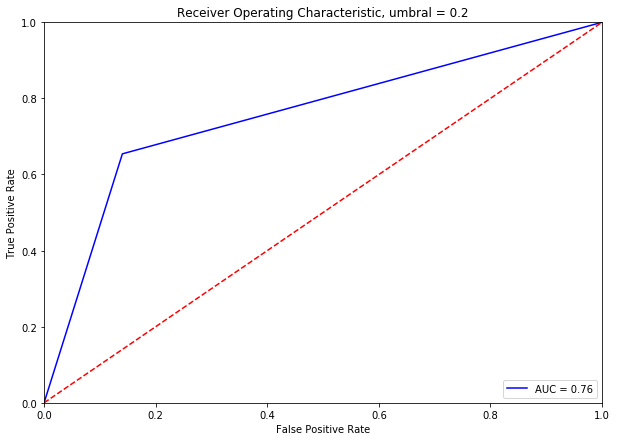

In [106]:
preds = y_umbralizadas
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic, umbral = '+str(umbral))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## 3er Modelo: Decision Tree



In [107]:
regr = DecisionTreeClassifier()

In [108]:
# establecemos los parámetros a optimizar, probaremos una profundidad del arbol entre 2 y 7 niveles

params = {"max_depth": range(2,8)}

In [109]:
""" 
Buscamos la mejor combinación de parámetros, con una validación cruzada de 5 conjuntos, para 
maximizar la métrica ROC AUC ( área bajo la curva ROC)
"""

regr_gs = GridSearchCV(regr, param_grid=params, cv=5, scoring= "roc_auc")

regr_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(2, 8)}, pre_dispatch='2*n_jobs',
 

In [110]:
print(regr_gs.best_params_, "\nROC AUC: {}".format(round(regr_gs.best_score_,2)))

{'max_depth': 5} 
ROC AUC: 0.91


In [111]:
df_search = pd.DataFrame.from_dict(regr_gs.cv_results_)

In [112]:
df_search[:2]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006204,4.002336e-04,0.002002,4.909339e-07,2,{'max_depth': 2},0.874577,0.882423,0.892891,0.867984,0.894409,0.882457,0.010230,6
1,0.009006,4.909339e-07,0.002001,2.431402e-07,3,{'max_depth': 3},0.914678,0.895806,0.909244,0.907771,0.905825,0.906665,0.006176,4


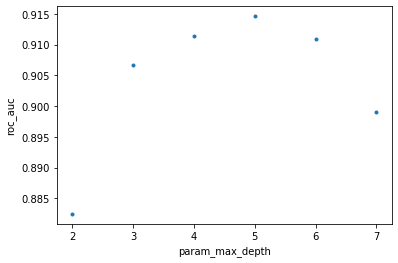

In [113]:
plt.xlabel('param_max_depth')
plt.ylabel('roc_auc')
_ = plt.plot( df_search['param_max_depth'], df_search['mean_test_score'], '.')

In [114]:
dec_tree = DecisionTreeClassifier(max_depth=regr_gs.best_params_['max_depth'])

Ajusto a todos los datos de entrenamiento, con los parámetros optimizados.

In [115]:
dec_tree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [116]:
y_test_pred_prob = dec_tree.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

In [117]:
round(roc_auc_score(Y_test, y_test_pred_prob[:,1]),2)

0.92

Con 5 niveles de profundidad se obtiene la mejor ROC_AUC, **0.92**, la mejor métrica hasta el momento.

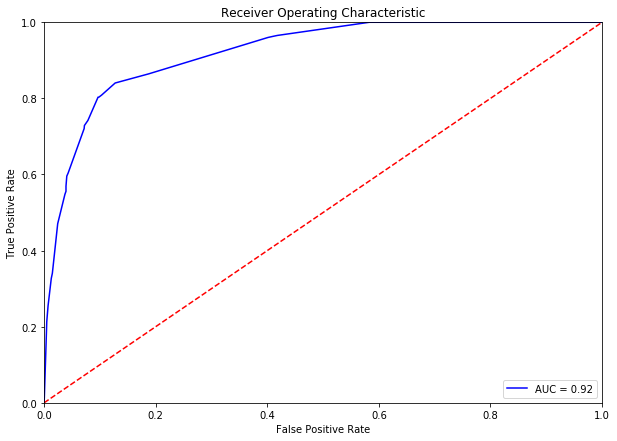

In [118]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

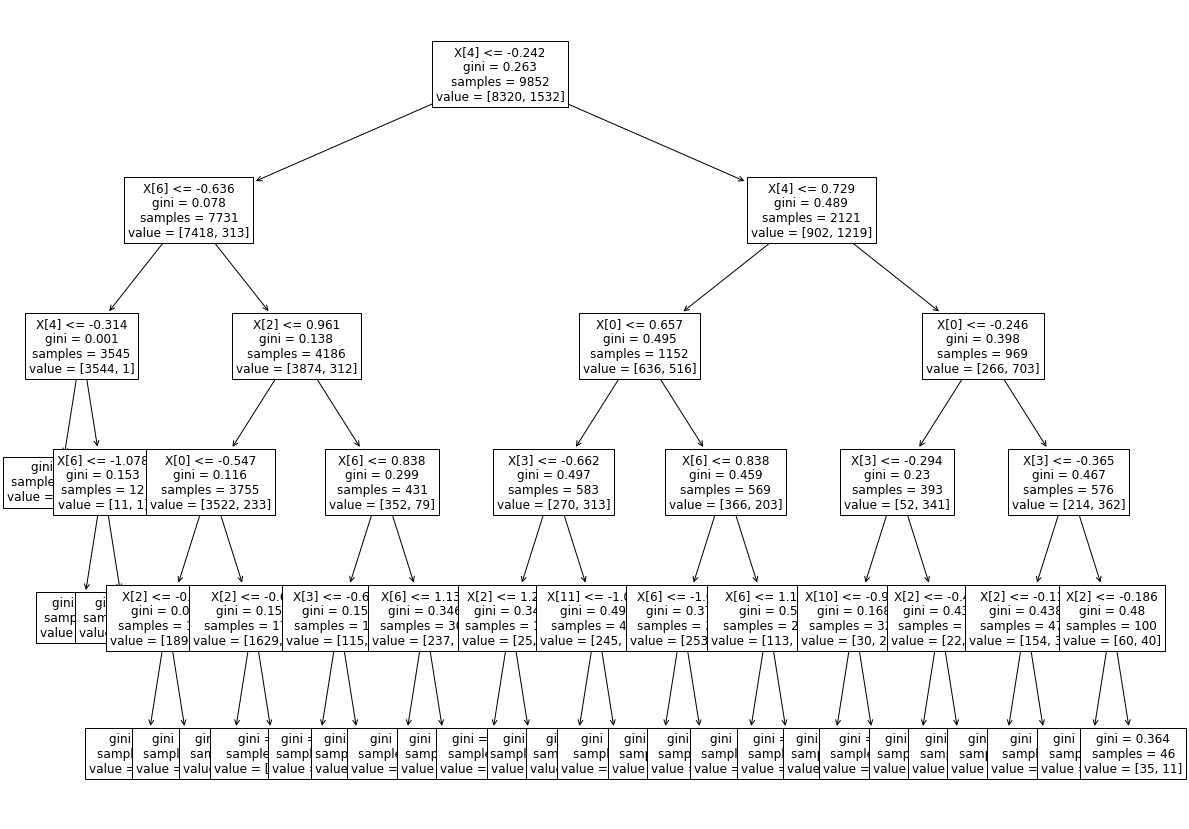

In [119]:
fig, ax = plt.subplots(figsize = (20,15))

tree.plot_tree(dec_tree,fontsize= 12, label= "all")

plt.show()

Si tenemos que umbralizar las probabilidades que asigna el modelo a cada observación, para maximizar el área bajo la curva ROC, podemos establecer el corte en 0.1 o 0.2 , obteniendo un AUC ROC de **0.86**.

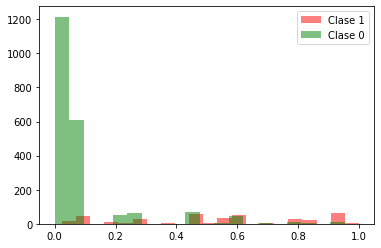

In [120]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

In [121]:
umbral = 0.2
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)

In [122]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))    

Matriz de confusión
 [[1822  266]
 [  60  316]]

Accuracy	0.87
Sensitividad	0.84
Precisión	0.54


In [123]:
round(roc_auc_score(Y_test, y_umbralizadas),2)

0.86

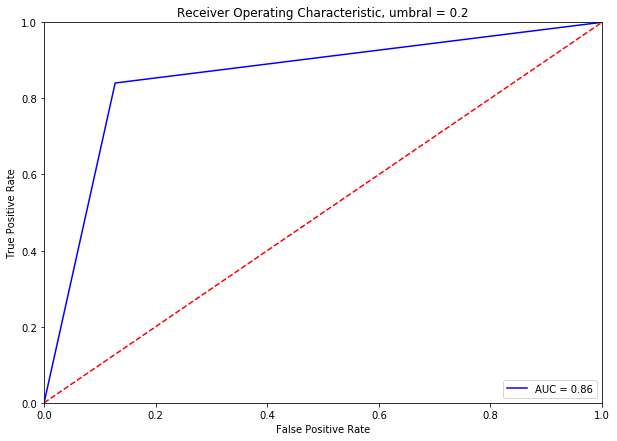

In [124]:
preds = y_umbralizadas
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic, umbral = '+str(umbral))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3er modelo: Redes Neuronales

Vamos a hacer uso de la librería sklearn. Esta librería cuenta con un clasificador llamado MLPClassifier, el cual es lo que se denomina un Multi-layer Perceptron Classifier.

Esta es la configuración más común y estándard de las redes neuronales. Cuentan con una capa de entrada, una de salida y múltiples capas ocultas. Se trata de una arquitectura de red neuronal fully-connected, es decir, las neuronas de cada capa se conectan a todas las neuronales de las capas anteriores y de las siguientes.

In [125]:
# Creamos el modelo y los parámetros a optimizar
modelo = MLPClassifier()
parametros = {'solver': ['lbfgs'], 
              'max_iter': [100,200,300,500], # Iteraciones máximas en cada red
              'alpha': 10.0 ** -np.arange(1, 3), # Parámetro de regularización L2 para evitar sobreajuste
              'hidden_layer_sizes':np.arange(30, 35)} # Número de neuronas en cada capa


In [126]:
# optimizamos con GridSearch y una validación cruzada de 5 divisiones

modelo_gs = GridSearchCV(modelo, param_grid=parametros, cv = 5, 
                         scoring='roc_auc', n_jobs=-1, verbose=10)


modelo_gs.fit(X_train, Y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'

In [127]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'alpha': 0.01, 'hidden_layer_sizes': 32, 'max_iter': 100, 'solver': 'lbfgs'} 
ROC AUC: 0.91


Con los parámetros optimizados obtendríamos una métrica ROC de **0.91** para el conjunto de entrenamiento.

Igual que en el resto de modelos, utilizamos los mejores parámetros encontrados y ajustamos un modelo con esos parámetros:

In [128]:
mejor_modelo = MLPClassifier(**modelo_gs.best_params_, verbose=10)

mejor_modelo.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=32, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

Con la red neuronal optimizada y entrenada, analizamos las predicciones.

In [129]:
y_test_pred_prob = mejor_modelo.predict_proba(X_test) 
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

In [130]:
roc_auc_score(Y_test, y_test_pred_prob[:,1])

0.9109093502893943

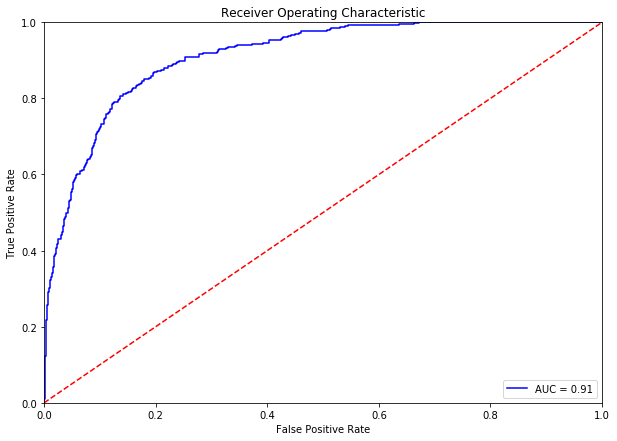

In [131]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Obtenemos una métrica AUC ROC de **0.91** sobre el conjunto de test, prácticamente la misma que para el árbol de decisión.

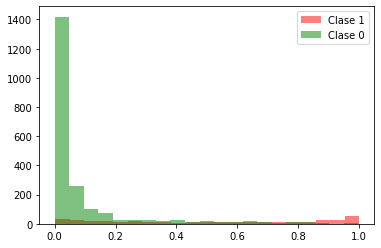

In [132]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

Las probabilidades que se asignan a la clase 0 son bastantes certeras, volveremos a utilizar un umbral bajo para maximizar el área bajo la curva ROC.

In [133]:
umbral = 0.1
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)

In [134]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))  

Matriz de confusión
 [[1695  393]
 [  55  321]]

Accuracy	0.82
Sensitividad	0.85
Precisión	0.45


In [135]:
roc_auc_score(Y_test, y_umbralizadas)

0.8327525067253607

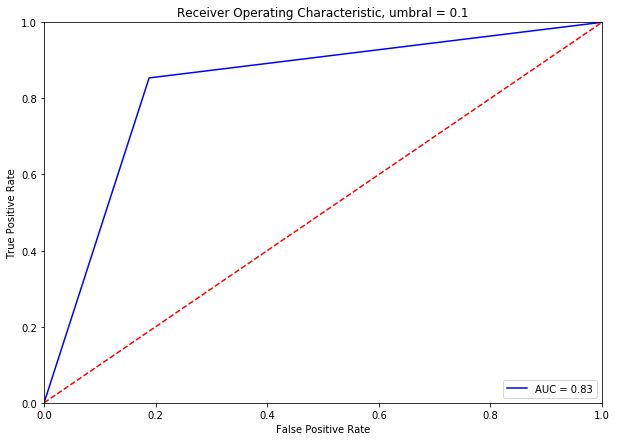

In [136]:
preds = y_umbralizadas
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic, umbral = '+str(umbral))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

El umbral 0.1 es el que maximiza la métrica AUC ROC (**0.83**) para el modelo de clasificación de red neuronal de sklearn.

### Red Neuronal con Tensorflow y Keras

Ahora desarrollaremos una red neuronal para clasificación con Tensorflow y Keras.

In [137]:
len(X.columns)

13

In [138]:
# Recordemos que teníamos 13 variables de entrada

X_train.shape[1]

13

La primera capa contiene 12 neuronas y define también la capa de entrada con el atributo input_dim. La
función de activación es la que se suele usar por defecto excepto en la capa de salida, la ReLU.

La segunda capa tiene ocho neuronas y función de activación ReLU.

Por último, la capa de salida tiene una sola neurona, y, como función de activación, la Sigmoid. La Sigmoid
sirve para problemas de clasificación binaria, como este caso.

In [139]:
model = Sequential()

model.add(Dense(12, input_dim= 13, activation = "relu"))

model.add(Dense(8, activation = "relu"))

model.add(Dense(1, activation = "sigmoid"))

Posteriormente a definir el modelo se realiza la compilación.
Para ello se definen una función de coste, un optimizador y una métrica.

Se definen las variables entrada X_train y salida Y_train .
Se define 150 como el número de épocas (todas las muestras se tienen en cuenta 150 veces).
El tamaño de lote se define en 10.

In [140]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [141]:
model.fit(X_train, Y_train, epochs=150, batch_size= 10)

Epoch 1/150
986/986 [==============================] - 1s 734us/step - loss: 0.5285 - accuracy: 0.7126
Epoch 2/150
986/986 [==============================] - 1s 727us/step - loss: 0.2871 - accuracy: 0.8804
Epoch 3/150
986/986 [==============================] - 1s 749us/step - loss: 0.2664 - accuracy: 0.8901
Epoch 4/150
986/986 [==============================] - 1s 729us/step - loss: 0.2515 - accuracy: 0.9003
Epoch 5/150
986/986 [==============================] - 1s 772us/step - loss: 0.2562 - accuracy: 0.8892
Epoch 6/150
986/986 [==============================] - 1s 710us/step - loss: 0.2506 - accuracy: 0.8955
Epoch 7/150
986/986 [==============================] - 1s 729us/step - loss: 0.2333 - accuracy: 0.9016
Epoch 8/150
986/986 [==============================] - 1s 771us/step - loss: 0.2416 - accuracy: 0.8987
Epoch 9/150
986/986 [==============================] - 1s 743us/step - loss: 0.2390 - accuracy: 0.9012
Epoch 10/150
986/986 [==============================] - 1s 841us/step - l

In [142]:
y_test_pred_prob = model.predict_proba(X_test) 
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

In [143]:
y_test_pred_prob.shape

(2464, 1)

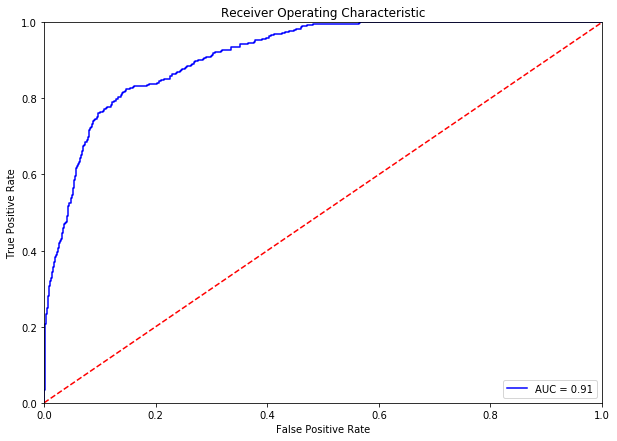

In [144]:
preds = y_test_pred_prob
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [145]:
round(roc_auc_score(Y_test, y_test_pred_prob),2)

0.91

Obtenemos un ROC AUC de **0.91** en el conjunto de test.

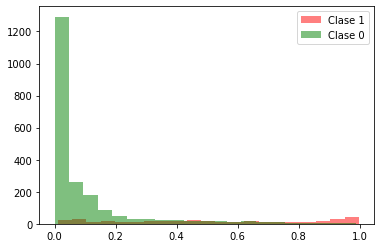

In [146]:
represento_doble_hist(y_test_pred_prob_pos, y_test_pred_prob_neg, n_bins=21, density=0)

In [147]:
umbral = 0.2
y_umbralizadas = 1*(y_test_pred_prob > umbral)

In [148]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2))) 

Matriz de confusión
 [[1832  256]
 [  79  297]]

Accuracy	0.86
Sensitividad	0.79
Precisión	0.54


In [149]:
roc_auc_score(Y_test, y_umbralizadas)

0.833644126518301

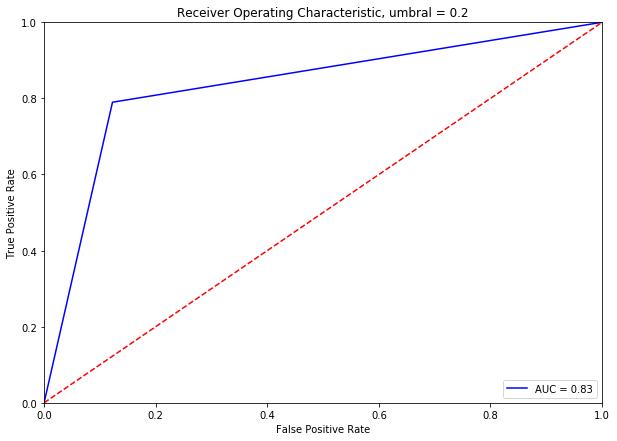

In [150]:
preds = y_umbralizadas
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic, umbral = '+str(umbral))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

En este caso, el umbral que maximiza al área bajo la curva ROC es 0.2, y obtiene un AUC ROC de **0.83**.

## Resumen de la fase de modelado.

Hemos utilizado una serie de modelos, que, una vez optimizados mediante GridSearch y validación cruzada, obtenemos las siguientes métricas ROC:
   
   + Una regresión logística, con un ROC de **0.89** en test, y **0.81** umbralizando.
   
   
   + Un modelo KNN (K vecinos más cercanos), no lineal, con una ROC de **0.85** en test y **0.76** umbralizando.
   
   
   + Un árbol de decisión (no lineal), con una ROC de __0.92__ en test y **0.86** umbralizando.
   
   
   + Una red neuronal de scikit-learn, con __0.91__ en test y __0.83__ umbralizando.
   
   
   + Una red neuronal de Tensorflow y Keras, __0.91__ en test y __0.83__ umbralizando.
   
   
Por tanto, a la vista de los resultados, y tomando el cuenta como métrica el área calculada bajo la curva ROC, el algoritmo más eficaz a la hora de predecir ventas en la web, sería el árbol de decisión, seguido muy de cerca por las redes neuronales.
   